In [0]:
# !pip install --user xgboost
# !pip install --user yellowbrick
# !pip install --user sklearn
# !pip install --user pydotplus

In [0]:
import pandas as pd
import numpy as np
from seaborn import heatmap as correlation_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt
from typing import AnyStr, List, Dict
from datetime import datetime
import folium
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

In [0]:
df = pd.read_csv("Processed_loans.csv")
df.head()

,Loan_ID,Channel,Seller,Interest_Rate,UPB,Loan_Term,Origination_Date,First_Payment_Date,LTV,CLTV,Num_Borrowers,DTI,Borrower_FICO,First_Time_Buyer,Loan_Purpose,Dwelling_Type,Unit_Count,Occupancy,State,Zip,Insurance%,Product,Mortgage_Insurance_Type,Relocation_Indicator,Period,Current_IR,Current_UPB,Age,Mod_Ind,Zero_Bal_Cd,FICO_bins,Term_bins,Current_Status,Origin_Month,Origin_Year
0,100118778860,R,OTHER,5.125,96000,360,03/2003,05/2003,95,95.0,1.0,36.0,746.0,N,P,SF,1,P,TX,787,30.0,FRM,1.0,N,201402,5.125,76987.70,130,N,Prepaid,740-780,<= 30 Years,Prepaid,5,2003
1,100329229881,R,OTHER,5.250,118000,180,05/2003,07/2003,75,75.0,2.0,59.0,740.0,N,R,SF,2,P,MA,27,0.0,FRM,0.0,N,201807,5.250,570.81,181,N,Prepaid,700-740,<=15 Years,Prepaid,7,2003
2,100366774784,R,"CITIMORTGAGE, INC.",5.375,64000,180,10/2003,12/2003,78,78.0,2.0,31.0,604.0,N,C,SF,1,P,NY,146,0.0,FRM,0.0,N,201807,5.375,555.64,176,N,Prepaid,0-620,<=15 Years,Prepaid,12,2003
3,100738728736,R,OTHER,5.125,60000,180,05/2003,07/2003,17,17.0,2.0,11.0,758.0,N,C,SF,1,P,RI,28,0.0,FRM,0.0,N,201502,5.125,1000.07,140,N,Prepaid,740-780,<=15 Years,Prepaid,7,2003
4,101006769982,C,"BANK OF AMERICA, N.A.",5.250,50000,360,05/2003,07/2003,80,80.0,2.0,20.0,779.0,N,P,SF,1,P,MO,638,0.0,FRM,0.0,N,201502,5.250,35290.05,140,N,Prepaid,740-780,<= 30 Years,Prepaid,7,2003


# Preprocess & Encode the labels to numerical Values

In [0]:
lb = LabelEncoder()

# Only contain month range from first payment to opening date
df["First_Payment_Date"] = pd.to_datetime(df["First_Payment_Date"], format = "%m/%Y")
df["Origination_Date"] = pd.to_datetime(df["Origination_Date"], format = "%m/%Y")
df["Months_Between_First_Payment_And_Origin_Date"] = np.floor( abs(df["First_Payment_Date"] - df["Origination_Date"]) / np.timedelta64(1, 'M') )

df["Channel"] = lb.fit_transform(df["Channel"])
# print("Channel: ", lb.classes_)
df["Seller"] = lb.fit_transform(df["Seller"])
# print("Seller: ", lb.classes_)
df["First_Time_Buyer"] = lb.fit_transform(df["First_Time_Buyer"])
# print("First Time Buyer: ", lb.classes_)
df["Loan_Purpose"] = lb.fit_transform(df["Loan_Purpose"])
# print("Loan_Purpose: ", lb.classes_)
df["Dwelling_Type"] = lb.fit_transform(df["Dwelling_Type"])
# print("Dwelling_Type: ", lb.classes_)
df["Occupancy"] = lb.fit_transform(df["Occupancy"])
# print("Occupancy: ", lb.classes_)
df["State"] = lb.fit_transform(df["State"])
# print("State: ", lb.classes_)
# df["Product"] = lb.fit_transform(df["Product"])
# print("Product: ", lb.classes_)
df["Relocation_Indicator"] = lb.fit_transform(df["Relocation_Indicator"])
# print("Relocation_Indicator: ", lb.classes_)
df["Mod_Ind"] = lb.fit_transform(df["Mod_Ind"])
# print("Mod_Ind: ", lb.classes_)
df["Zero_Bal_Cd"] = lb.fit_transform(df["Zero_Bal_Cd"])
# print("Zero_Bal_Cd: ", lb.classes_)
df["Term_bins"] = df["Term_bins"].map({"<= 30 Years": 30, "<=15 Years": 15})
# print("Term_bins: ", df["Term_bins"].unique())
df["Current_Status"] = lb.fit_transform(df["Current_Status"])
# print("Current_Status: ", lb.classes_)

In [0]:
df.drop(columns=['Loan_ID', 'Interest_Rate', 'Product', 'Origination_Date', 'First_Payment_Date', 'FICO_bins', 'Period', 'Zip'], inplace=True, errors = 'ignore')

# Correlation Matrix

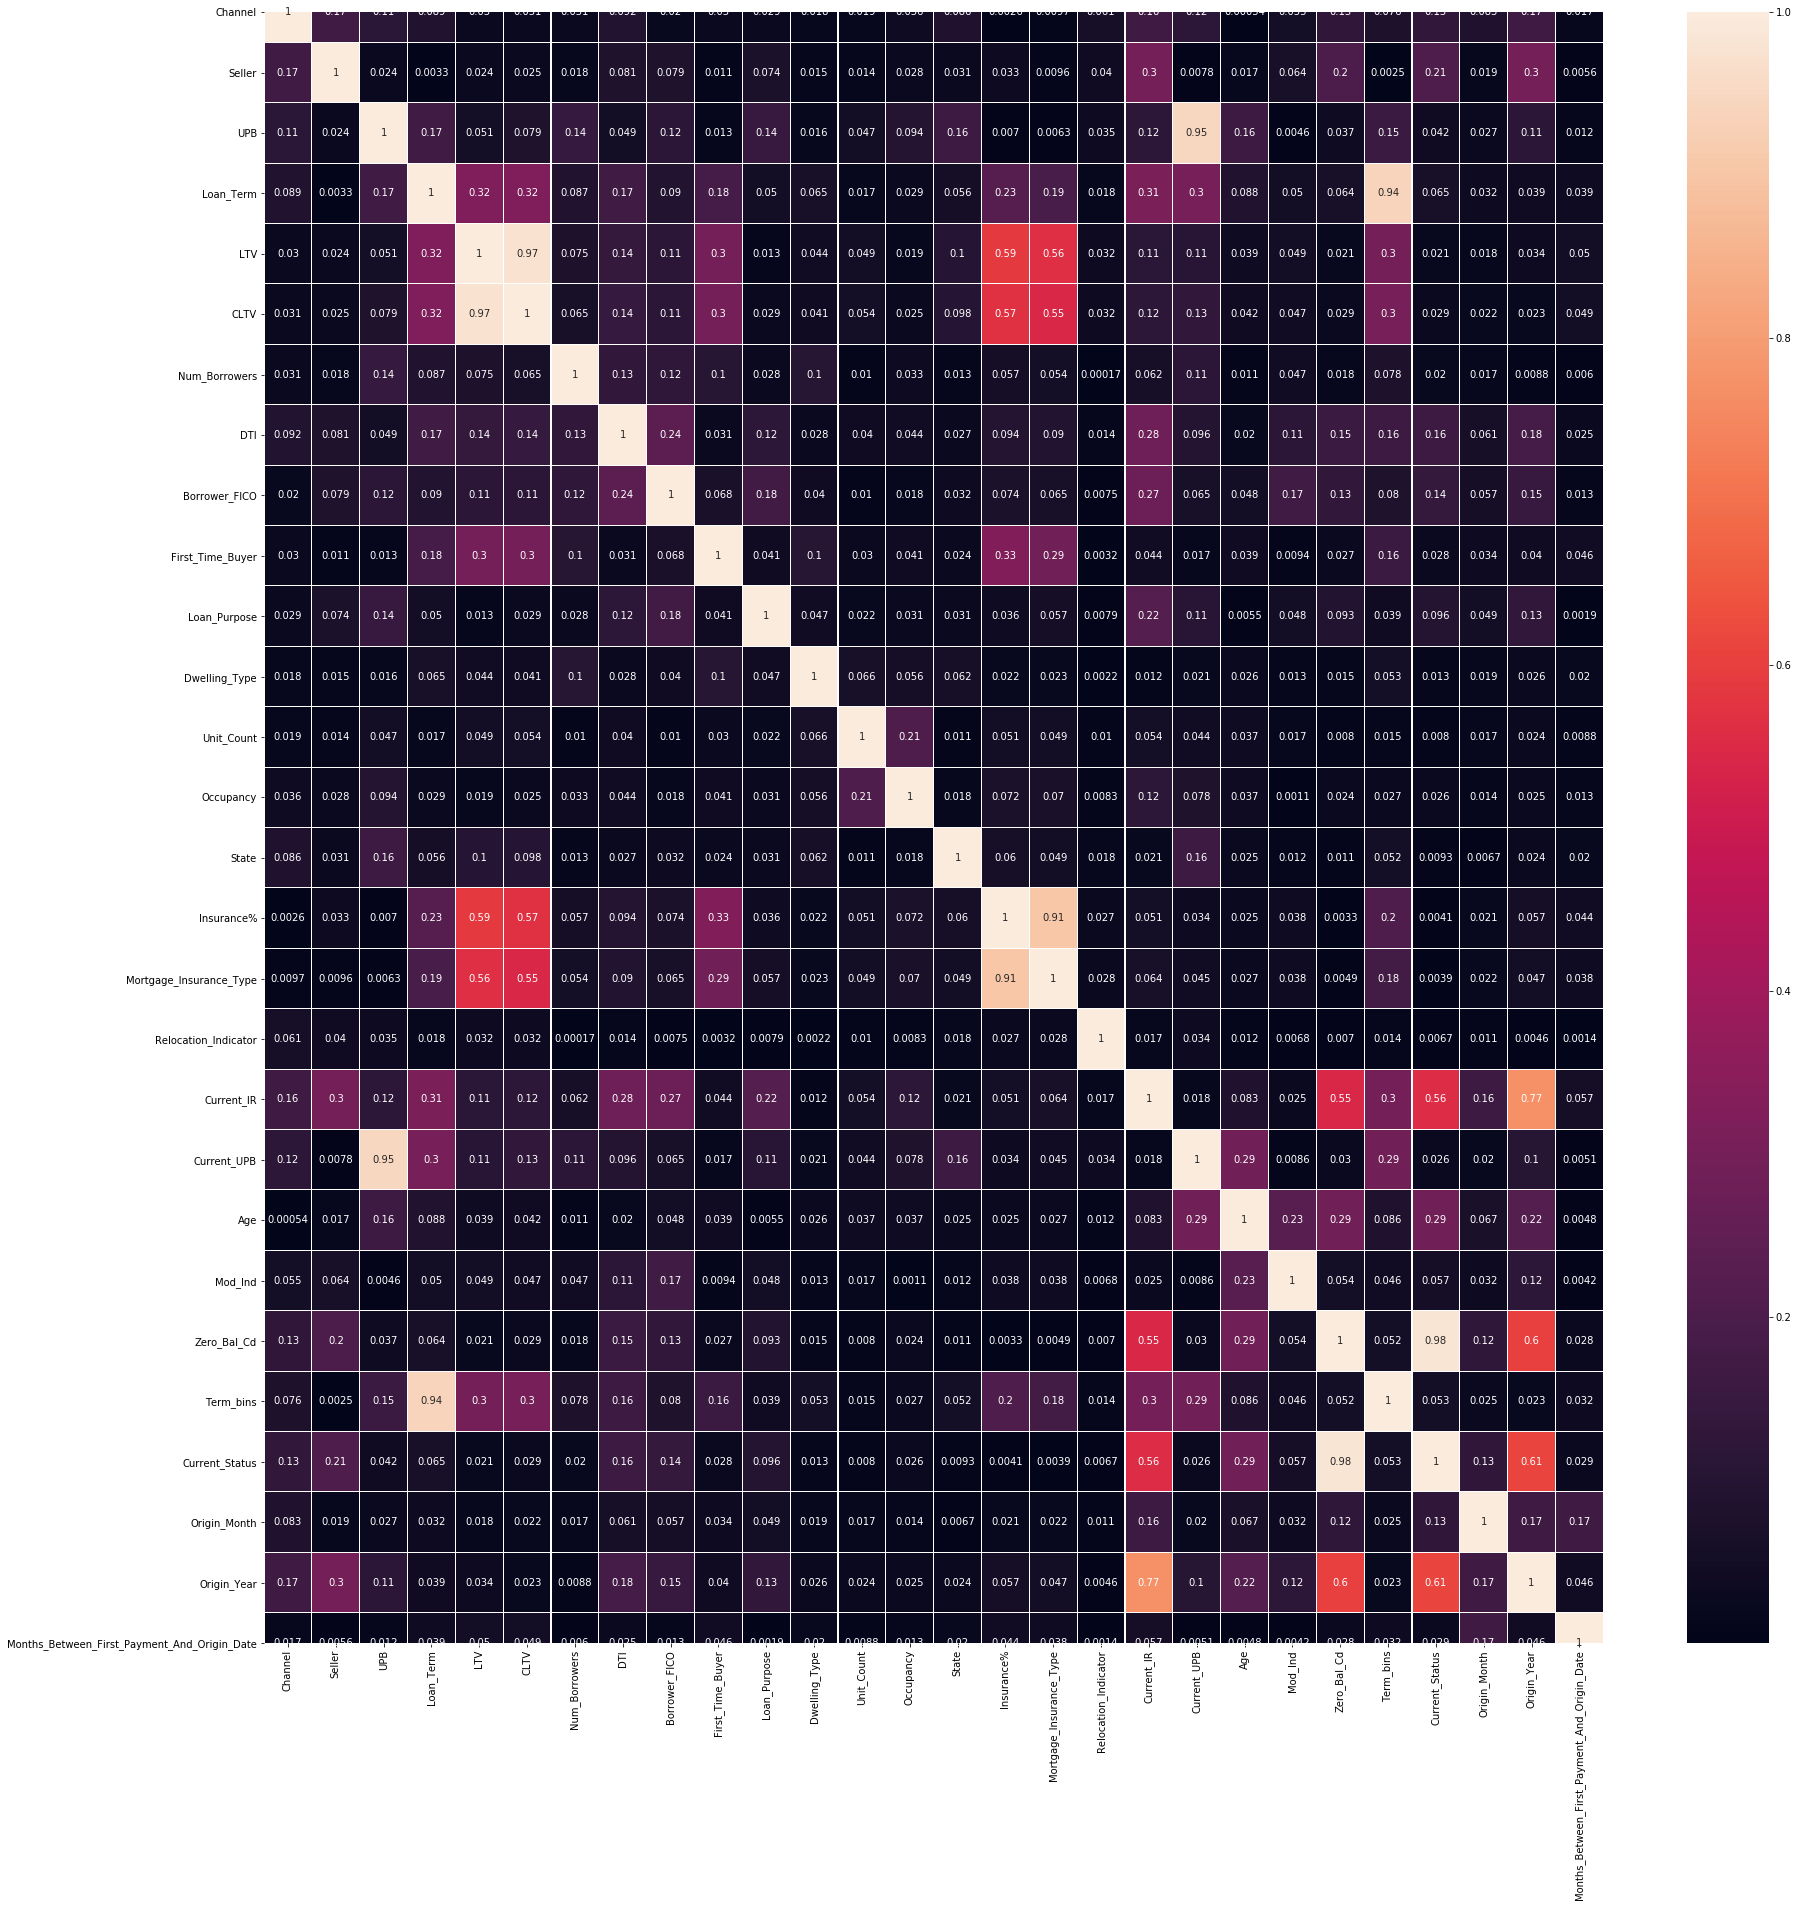

In [0]:
plt.figure(figsize=(30, 30))
correlation_matrix = df.corr().abs()
correlation_plot = heatmap(correlation_matrix, linewidths=0.1, annot = True)

In [0]:
# Drop Features that have high correlation to Current_Status
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

to_drop = [
    pair[0]
    for pair in zip(upper_triangle.columns, upper_triangle['Current_Status'] >= 0.5)
    if pair[1] >= 0.5
]
df.drop(df[to_drop], axis = 1, inplace = True, errors = 'ignore')

In [0]:
X = df.drop('Current_Status', axis = 1)
y = df['Current_Status']

In [0]:
def most_frequent_coorelated_features(coorelation_pairs):
    coorelated_frequencies = {}
    for pair in coorelation_pairs:
        for feature in pair:
            if feature in coorelated_frequencies:
                coorelated_frequencies[feature] += 1
            else:
                coorelated_frequencies[feature] = 1
    return coorelated_frequencies

In [0]:
def best_correlated_feature(
    correlation_matrix: pd.core.frame.DataFrame,
    threshhold: float = 0.5):
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

    correlation_pairs = {
        upper_triangle[row][col] : [row, col]
        for row in upper_triangle.columns
        for col in upper_triangle.columns
        if (upper_triangle[row][col] >= threshhold)
    }
    if len(correlation_pairs) == 0:
        return None
    coorelations = most_frequent_coorelated_features(correlation_pairs.values())

    most_coorelated_value = max(correlation_pairs)
    feature_1, feature_2 = correlation_pairs[most_coorelated_value]

    # print(correlation_pairs)
    # print(coorelations)

    return feature_1 if coorelations[feature_1] <= coorelations[feature_2] else feature_2 

In [0]:
correlation_matrix = X.corr().abs()
correlation_pairs = best_correlated_feature(correlation_matrix)

while correlation_pairs:
    X.drop(columns=[correlation_pairs], inplace=True, errors = 'ignore')
    correlation_matrix = X.corr().abs()
    correlation_pairs = best_correlated_feature(correlation_matrix)

In [0]:
df = X
df['Current_Status'] = y


In [0]:
df

,Channel,Seller,UPB,Loan_Term,LTV,Num_Borrowers,DTI,Borrower_FICO,First_Time_Buyer,Loan_Purpose,Dwelling_Type,Unit_Count,Occupancy,State,Relocation_Indicator,Age,Mod_Ind,Origin_Month,Origin_Year,Months_Between_First_Payment_And_Origin_Date,Current_Status
0,2,31,96000,360,95,1.0,36.0,746.0,0,1,4,1,1,45,0,130,0,5,2003,2.0,1
1,2,31,118000,180,75,2.0,59.0,740.0,0,2,4,2,1,20,0,181,0,7,2003,2.0,1
2,2,10,64000,180,78,2.0,31.0,604.0,0,0,4,1,1,35,0,176,0,12,2003,2.0,1
3,2,31,60000,180,17,2.0,11.0,758.0,0,0,4,1,1,41,0,140,0,7,2003,2.0,1
4,1,3,50000,360,80,2.0,20.0,779.0,0,1,4,1,1,25,0,140,0,7,2003,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304071,2,46,169000,180,71,1.0,42.0,752.0,0,2,4,1,1,35,0,35,0,8,2016,2.0,0
304072,2,31,123000,360,95,2.0,44.0,685.0,2,1,4,1,1,45,0,33,0,10,2016,2.0,0
304073,2,31,124000,360,80,2.0,26.0,785.0,0,1,4,1,1,10,0,33,0,10,2016,2.0,0
304074,1,46,101000,360,75,1.0,14.0,782.0,2,1,0,1,1,24,0,33,0,10,2016,2.0,0


In [0]:
df.to_csv("data.csv", index = False)

<hr>

<div id="modeling">
    <h2>Modeling</h2>
    We will first create an instance of the <b>DecisionTreeClassifier</b> called <b>dTree</b>.<br>
</div>

In [0]:
my_data = pd.read_csv("FannieMae_data.csv", delimiter=",")
my_data.drop(my_data.columns[0], axis=1, inplace=True)
# my_data.drop("FICO_bins",1, inplace=True)
# my_data.drop("Zero_Bal_Cd",1, inplace=True)
# my_data.drop("Period",1, inplace=True)
# my_data.drop("Age",1, inplace=True)
X = my_data.drop('Current_Status',axis=1)
y = my_data['Current_Status']
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

In [0]:
dTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dTree.fit(X_trainset,y_trainset)
feature_importance = dict(zip(X.columns, dTree.feature_importances_))
display(sorted(feature_importance))

['Age',
 'Borrower_FICO',
 'Channel',
 'DTI',
 'Dwelling_Type',
 'First_Payment_Months',
 'First_Time_Buyer',
 'LTV',
 'Loan_Purpose',
 'Loan_Term',
 'Mod_Ind',
 'Num_Borrowers',
 'Occupancy',
 'Origin_Month',
 'Origin_Year',
 'Relocation_Indicator',
 'Seller',
 'State',
 'UPB',
 'Unit_Count']

In [0]:
predTree = dTree.predict(X_testset)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))
print(type(predTree))
print(classification_report(y_testset, predTree, labels=[0, 1, 2]))

DecisionTrees's Accuracy:  0.9667846924569462
<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     43240
           1       0.96      0.98      0.97     46160
           2       0.00      0.00      0.00      1823

    accuracy                           0.97     91223
   macro avg       0.64      0.66      0.65     91223
weighted avg       0.95      0.97      0.96     91223



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.metrics import precision_recall_fscore_support

def plot_classification_report(y_tru, y_prd, figsize=(20, 20), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)

plot_classification_report(y_testset, predTree)

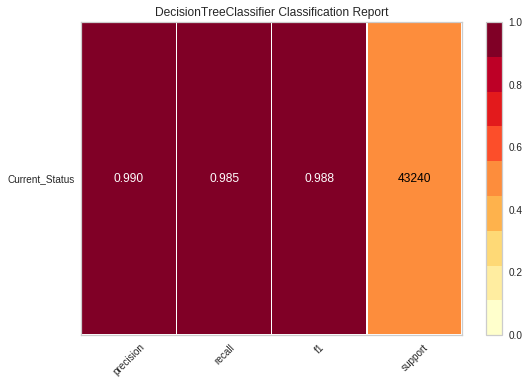

In [0]:
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
bayes = DecisionTreeClassifier()
visualizer = ClassificationReport(bayes, classes=['Current_Status'], cmapstring='YlGnBu', support=True)

visualizer.fit(X_trainset, y_trainset)  # Fit the visualizer and the model
visualizer.score(X_testset, y_testset)  # Evaluate the model on the test data'
visualizer.poof()       

In [0]:
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, X, y, cv=10)

array([0.70879374, 0.94461984, 0.94702052, 0.94840174, 0.95007893,
       0.95149303, 0.96836359, 0.96885688, 0.96645399, 0.95632441])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


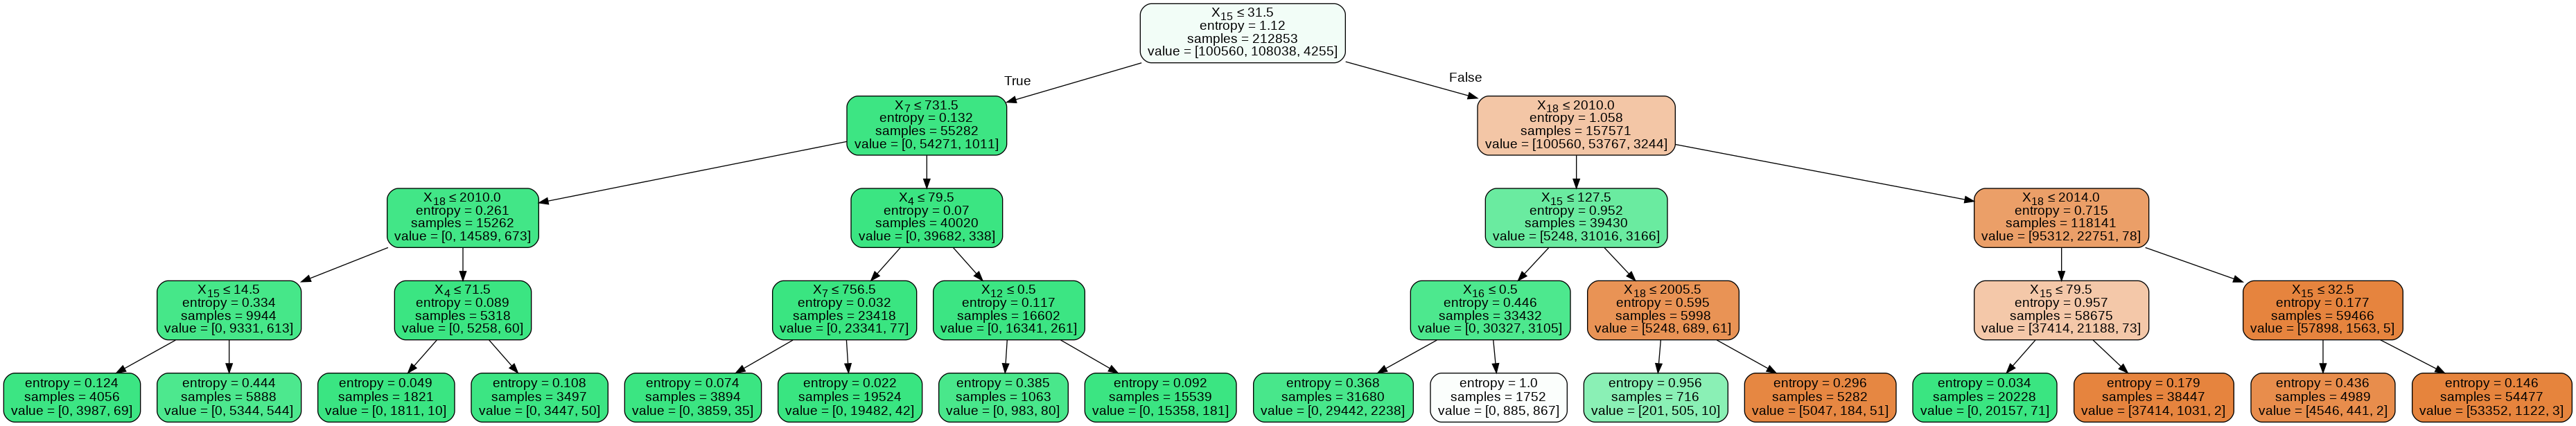

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dTree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances

# Load the classification data set


model = RandomForestClassifier(n_estimators=100, n_jobs = -1)
viz = FeatureImportances(model, relative=False)
viz.fit(X_trainset, y_trainset)
viz.show()

ImportError: ignored

In [0]:
#Create a Gaussian Classifier
clf2=RandomForestClassifier(n_estimators=100, n_jobs = -1)

clf2.fit(X_trainset,y_trainset)

y_pred=clf2.predict(X_testset)
print("Accuracy:",metrics.accuracy_score(y_testset, y_pred))
feature_importance = dict(zip(X.columns, clf2.feature_importances_))
display(sorted(feature_importance))

Accuracy: 0.9742170286002434


['Age',
 'Borrower_FICO',
 'Channel',
 'DTI',
 'Dwelling_Type',
 'First_Payment_Months',
 'First_Time_Buyer',
 'LTV',
 'Loan_Purpose',
 'Loan_Term',
 'Mod_Ind',
 'Num_Borrowers',
 'Occupancy',
 'Origin_Month',
 'Origin_Year',
 'Relocation_Indicator',
 'Seller',
 'State',
 'UPB',
 'Unit_Count']

In [0]:
print(classification_report(y_testset, y_pred, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     43240
           1       0.97      0.98      0.98     46160
           2       0.71      0.12      0.21      1823

    accuracy                           0.97     91223
   macro avg       0.89      0.70      0.73     91223
weighted avg       0.97      0.97      0.97     91223



XGBoost

In [0]:
model = XGBClassifier(learning_rate=0.001, max_depth=4, min_child_weight=17, n_estimators=100, nthread=1, subsample=0.7000000000000001)
model.fit(X_trainset, y_trainset)
y_pred = model.predict(X_testset)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_testset, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.82%


In [0]:
print(classification_report(y_testset, y_pred, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     43240
           1       0.96      0.97      0.97     46160
           2       0.72      0.06      0.11      1823

    accuracy                           0.97     91223
   macro avg       0.89      0.68      0.69     91223
weighted avg       0.96      0.97      0.96     91223



Extra Tree Classifier

In [0]:
forest = ExtraTreesClassifier(bootstrap=True, criterion='gini', max_features=0.6500000000000001, min_samples_leaf=18, min_samples_split=20, n_estimators=100)
forest.fit(X_trainset, y_trainset)
y_pred = forest.predict(X_testset)
print("Accuracy:",metrics.accuracy_score(y_testset, y_pred))
print(classification_report(y_testset, y_pred, labels=[0, 1, 2]))

Accuracy: 0.9740087477938678
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     43240
           1       0.97      0.98      0.97     46160
           2       0.70      0.12      0.21      1823

    accuracy                           0.97     91223
   macro avg       0.88      0.70      0.72     91223
weighted avg       0.97      0.97      0.97     91223



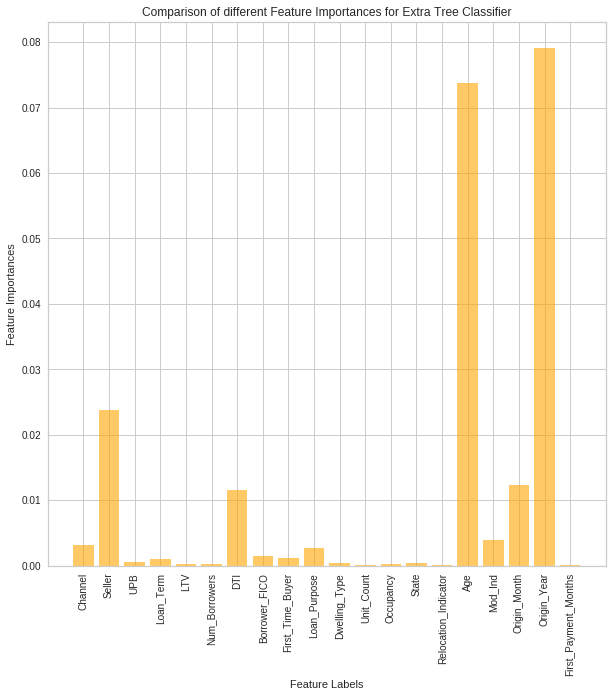

In [0]:
feature_importance = forest.feature_importances_ 
  
# Normalizing the individual importances 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        forest.estimators_], 
                                        axis = 0)
plt.figure(figsize=(10, 10))
plt.bar(X_testset.columns, feature_importance_normalized, color='orange', alpha=0.6) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances') 
plt.title('Comparison of different Feature Importances for Extra Tree Classifier') 
plt.xticks(rotation=90)
plt.show() 

# Determine Most Important Features

In [0]:
df2 = pd.read_csv('Processed_loans.csv')
df2["Current_Status"] = lb.fit_transform(df2["Current_Status"])
# print("Current_Status: ", lb.classes_)
df3 = df2.groupby('State')['Current_Status'].apply(lambda x: x.value_counts().index[0]).reset_index()
df3['Borrower_FICO'] = df2.groupby(['State'])['Borrower_FICO'].mean().reset_index()['Borrower_FICO']
df3['Origin_Year'] = df2.groupby('State')['Origin_Year'].apply(lambda x: x.value_counts().index[0]).reset_index()['Origin_Year']
df3.drop([7,11,40,48], inplace=True)
df3

,State,Current_Status,Borrower_FICO,Origin_Year
0,AK,1,748.708527,2012
1,AL,1,748.553390,2008
2,AR,1,751.895034,2012
3,AZ,1,755.667063,2016
4,CA,1,763.293568,2012
5,CO,1,762.470474,2016
6,CT,0,755.478882,2012
8,DE,1,757.521277,2008
9,FL,1,746.403808,2016
10,GA,1,751.736463,2008


Maps


In [0]:
import os
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it
state_geo = os.path.join('/content/', 'us-states.json')
 
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)

# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=df3,
 columns=['State', 'Origin_Year'],
 key_on='feature.id',
 fill_color='RdYlBu',
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='Origin Year',
)
folium.LayerControl().add_to(m)
m.save('index.html')

display(m)

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [0]:
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)

# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=df3,
 columns=['State', 'Borrower_FICO'],
 key_on='feature.id',
 fill_color='YlOrRd',
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='FICO Score',
)
folium.LayerControl().add_to(m)
m.save('index.html')

display(m)

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [123]:
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)
# ,tiles='CartoDB dark_matter'

# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=df3,
 columns=['State', 'Current_Status'],
 key_on='feature.id',
 fill_color='RdYlBu',
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='Current Loan Status',
)
folium.LayerControl().add_to(m)
m.save('index.html')

display(m)

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


FICO vs Unpaid Balance with Current Status as defining factor

Text(0.5, 1.0, 'Scatter plot showing correlation between FICO Score and the Unpaid Principal Balance for different loan status')

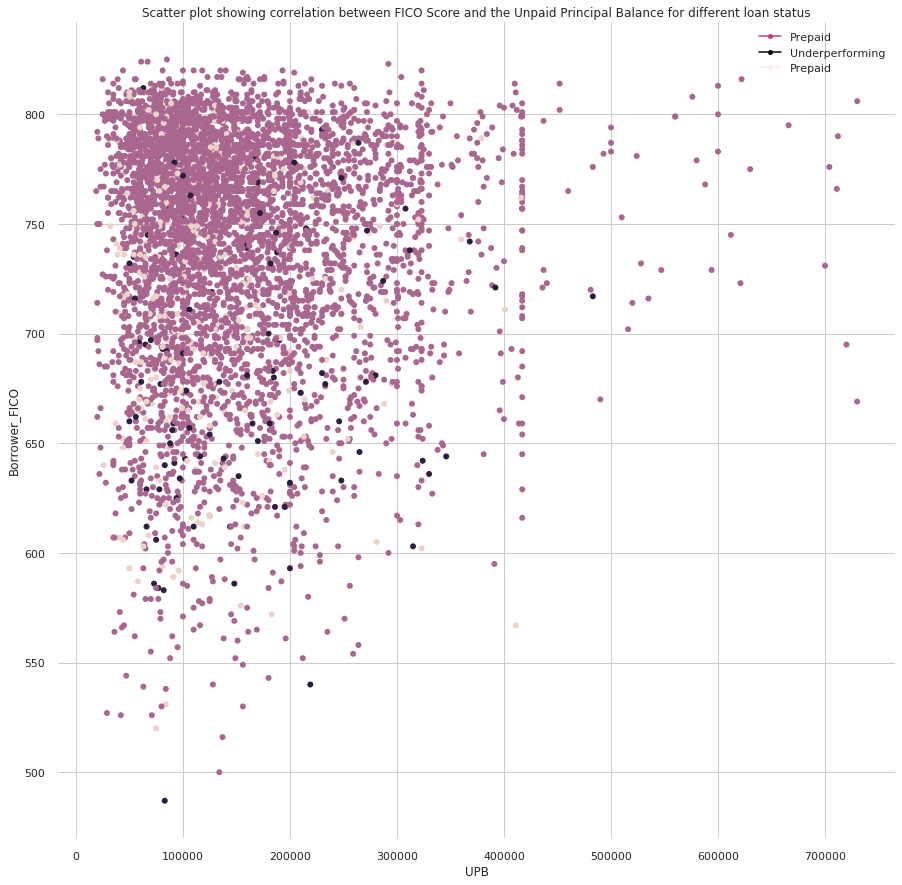

In [0]:
from matplotlib.lines import Line2D

sns.set(style="whitegrid")

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(15, 15))
sns.despine(f, left=True, bottom=True)
g = sns.scatterplot(x="UPB", y="Borrower_FICO", hue="Current_Status",sizes=(1, 8), linewidth=0,
                data=df.head(5000), ax=ax)
plt.legend(title='Current Loan Status', loc='upper right', labels=['Underperforming', 'Prepaid', 'Current'])

legend_elements = [Line2D([0], [0], marker='o', color='#bf4080', label='Prepaid',
                          markersize=5),
                   Line2D([0], [0], marker='o', color='black', label='Underperforming',
                           markersize=5),
                   Line2D([0], [0], marker='o', color='#f8ecf2', label='Prepaid',
                          markersize=5)
                   ]

plt.legend(handles=legend_elements, loc='upper right')
 
plt.title("Scatter plot showing correlation between FICO Score and the Unpaid Principal Balance for different loan status")


Current Status v Loan Purpose 

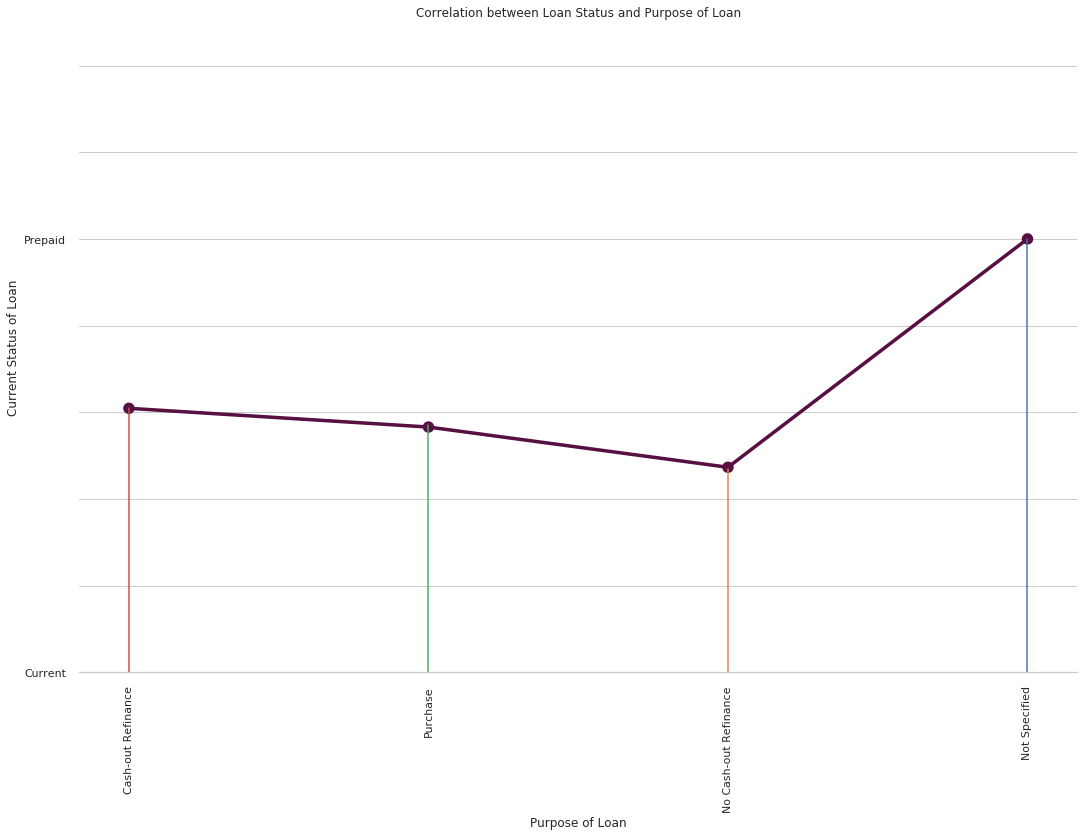

In [0]:
sns.set(style="whitegrid")


# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(df, y_vars="Current_Status",
                 x_vars=["Loan_Purpose"],
                 height=10, aspect=1.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, scale=1.3, errwidth=4, color="xkcd:plum")
g.set(ylim=(0, 1.5))
# g.set(yitcklabels=['Cash-out Refinance', 'Purchase', 'No Cash-out Refinance','Not Specified'])
g.set(xticklabels=['Cash-out Refinance', 'Purchase', 'No Cash-out Refinance','Not Specified'])
for ax in g.axes.flatten(): 
    for tick in ax.get_xticklabels(): 
        tick.set(rotation=90)

labels = [item.get_text() for item in ax.get_yticklabels()]

for i in range(len(labels)):
  labels[i] = ' '
labels[0] = 'Current'
labels[5] = 'Prepaid'
g.set(yticklabels=labels)
g.set(ylabel="Current Status of Loan")
g.set(xlabel="Purpose of Loan")
plt.title("Correlation between Loan Status and Purpose of Loan")
sns.despine(fig=g.fig, left=True)
plt.plot([3, 3], [0, 1])
plt.plot([2, 2], [0, 0.47])
plt.plot([1, 1], [0, 0.57])
plt.plot([0, 0], [0, 0.61])


Current Status v Origination Channel


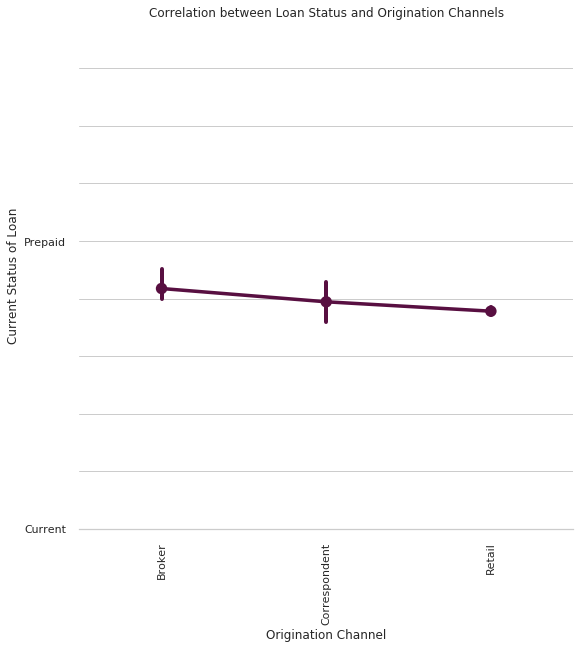

In [0]:
sns.set(style="whitegrid")


# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(df.head(1000), y_vars="Current_Status",
                 x_vars=["Channel"],
                 height=8, aspect=1)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, scale=1.3, errwidth=4, color="xkcd:plum")
g.set(ylim=(0, 2.2))
g.set(xticklabels=['Broker', 'Correspondent', 'Retail'])
for ax in g.axes.flatten(): 
    for tick in ax.get_xticklabels(): 
        tick.set(rotation=90)

labels = [item.get_text() for item in ax.get_yticklabels()]

for i in range(len(labels)):
  labels[i] = ' '
labels[0] = 'Current'
labels[5] = 'Prepaid'
g.set(yticklabels=labels)
g.set(ylabel="Current Status of Loan")
g.set(xlabel="Origination Channel")
plt.title("Correlation between Loan Status and Origination Channels")
sns.despine(fig=g.fig, left=True)


Histograms to compare different status with first payment time

In [0]:
dfU = (df.loc[df['Current_Status'] == 2])
dfP = (df.loc[df['Current_Status'] == 1])
dfC = (df.loc[df['Current_Status'] == 0])

In [0]:
x1 = dfU['First_Payment_Months']
x2 = dfP['First_Payment_Months']
x3 = dfC['First_Payment_Months']


num_bins = 3
n, bins, patches = plt.hist(x1, num_bins, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(4), ('                              0 Months', 
                          '                             1 Month', 
                          '                             2 Months'))
plt.ylim([0,14000])
plt.title("Time taken to make the first payment (by the number of loans) by Underperforming Loans")
plt.show()

KeyError: ignored

In [0]:
n, bins, patches = plt.hist(x2, num_bins, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(4), ('                              0 Months', 
                          '                             1 Month', 
                          '                             2 Months'))
plt.title("Time taken to make the first payment (by the number of loans) by Prepaid Loans")
plt.show()

In [0]:
n, bins, patches = plt.hist(x3, num_bins, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(4), ('                              0 Months', 
                          '                             1 Month', 
                          '                             2 Months'))
plt.title("Time taken to make the first payment (by the number of loans) by Current Loans")
plt.show()

Histograms to compare different status with first payment time

In [0]:
x1 = (df.loc[df['Current_Status'] == 0])['Num_Borrowers']
x2 = (df.loc[df['Current_Status'] == 1])['Num_Borrowers']
x3 = (df.loc[df['Current_Status'] == 2])['Num_Borrowers']


plt.figure(figsize=(10, 10))

num_bins = 7
n, bins, patches = plt.hist(x1, num_bins, facecolor='#009933', alpha=0.7)
plt.title("Number of Current loans vs. Number of Burrowers")
plt.show()

In [0]:
plt.figure(figsize=(10, 10))

num_bins = 7
n, bins, patches = plt.hist(x2, num_bins, facecolor='#0099AB', alpha=0.7)
plt.title("Number of Prepaid loans vs. Number of Burrowers")
plt.show()

In [0]:
plt.figure(figsize=(10, 10))

num_bins = 7
n, bins, patches = plt.hist(x3, num_bins, facecolor='red', alpha=0.7)
plt.title("Number of Underperforming loans vs. Number of Burrowers")
plt.xticks([1, 2, 3, 4])
plt.show()